## Binary images (129x129 pixels) of the microstructures sliced from 3-D morphologies which obtained by solving the Cahn-Hilliard equation
* We generate the CH dataset of 3-D microstructure using a thermodynamic consistent binary phase separation simulation. This is done by solving the well known Cahn-Hilliard equation [1]. Originally proposed to study phase separation in alloys, this equation can account for such phenomena in polymers, ceramics, and other material systems.
* Data from simulations with 8388608 (256x256x128) elements-8 nodes each, which is saved in a .h5 file [2].
* The dataset is 128 simulations (128 h5 files) which, after slicing and patching, will be 1011712 images with 129x129 binary pixels in resoluton. Please note that number of images in the dataset is a variable based on the number of slices in X or Y directions, and steps between time steps.  

[1] John W Cahn. "On spinodal decomposition". In: Acta metallurgica 9.9 (1961), pp. 795-801.
[2] For reading more about h5 files, see:   https://www.pythonforthelab.com/blog/how-to-use-hdf5-files-in-python/

In [5]:
%reset

### Importing required packages

In [6]:
import os
from tqdm import tqdm
import h5py  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Slicing core function 
- This function takes a pandas.core.frame.DataFrame type dataframe (data_frame0) and return two pandas.core.series.Series type series. 
- data_frame0 contains node coordinates and phi values (approximately for each morphology or timestep, data_frame0.shape = (8520321, 4))

In [7]:
def slicing(data_frame0):
    # grouping the data frame (data_frame0) by X values
    data_frame_sec_X=data_frame0.groupby('X').apply(pd.DataFrame.to_numpy) 
    
    # grouping the data frame (data_frame0) by Y values
    data_frame_sec_Y=data_frame0.groupby('Y').apply(pd.DataFrame.to_numpy)
    
    return data_frame_sec_X, data_frame_sec_Y

### Setting directory, and reading names of the files:
Note: to avoid any unpredicted errors, please make two seprate directories for reading and writing

In [12]:
reading_directory = './all_data/'
writing_directory = './writing/'

name_files = os.listdir(path=reading_directory)

FileNotFoundError: [Errno 2] No such file or directory: './all_data/'

### Geometry parameters:
* width : number of nodes along width (X, Y-dirs)
* height : number of nodes along height (Z-dir)
* numb_sections : number of the slices you need in both X-dir and Y-dir (you can change it if you want to change the 
                distance between the slices, e.g. we have one slice every 5 steps)
* sec_location: by knowing that the dimension of the sample is (Ux, Uy, Uz)=(4, 4, 2), and because we slice on X-dir 
                and Y-dir, we define sec_location which shows the location of the slices in X-dir and Y-dir 
* patch_1, patch_2 : since we need to make two 129x129 images (patches) from 257x129 images, we need to define patch_1 
                and patch_2 in which we can find the indices we need to this end. 

In [9]:
width = 257 
height = 129

sec_location = np.linspace(0.0, 4.0, width) 

num_sections = len(sec_location[np.arange(0, width, 5)])

patch_1 = np.array_split(np.arange(height * width).reshape(height, width), 2, axis=1)[0].flatten()
patch_2 = patch_1 + height - 1

### Reading, slicing, and saving the dataset 
* time_interval : this is a numpy array used to define the time interval that we want to extract the information 
                from the solution which is saved in the dataset. Note that we start from time step number 8 because 
                solutions at the very beginning of the dataset do not phase separate fully.
* data_frame : this is a pandas dataframe which includes (X, Y, Z, phi) features
* saving_frames : this is numpy array in which we save phi values of all the slices we create

In [10]:
# Iterating over names of the files (*.h5) in the reading_directory

writing_data = h5py.File(writing_directory + 'sliced_dataset.h5', 'w')
k = 1
for names in name_files:

    writing_group = writing_data.create_group('file_'+str(k-1))
    h5File = h5py.File(reading_directory + names, 'r')
    
    keys_list = list(h5File.keys())
    time_interval = np.arange(8, len(keys_list), 2)

    saving_frames = np.zeros((num_sections*4, height*height))
    # Iterating over the time stamps
    for timestep in tqdm(time_interval): 
        # Reading the data set related to the current timestep in the loop
        data_set = h5File[keys_list[timestep]] 
        
        # Extracting 8520321 (257x257x129) nodes with 3 (xyz) coordinates from the read_data_set 
        n_coord = np.array(data_set.get('node_coords')) 
        
        # Extracting values of phi on 8520321 (257x257x129) nodes
        phi_values = np.array(data_set.get('node_data').get('phi')) 
        
        # Concatenation of n_coord and phi_values in a pandas dataframe and name the columns properly
        data_frame = pd.concat([pd.DataFrame(n_coord,columns=['X','Y','Z']),
                        pd.DataFrame(phi_values,columns=['phi'])], 
                        axis=1, sort=False)
        
        # Calling slicing function to group by the dataset based on the X and Y coordinates 
        data_sliced = slicing(data_frame)
        slices_x = data_sliced[0]
        slices_y = data_sliced[1]
        
        # Dividing the images obtained from the slicing functions in half by using indices saved in patch_1 and 
        # patch_2 arrays 
        for j, i in enumerate(range(0, num_sections*4, 4)):
            saving_frames[i] = slices_x[sec_location[j]][:,3][patch_1]
            saving_frames[i+1] = slices_x[sec_location[j]][:,3][patch_2]
            saving_frames[i+2] = slices_y[sec_location[j]][:,3][patch_1]    
            saving_frames[i+3] = slices_y[sec_location[j]][:,3][patch_2]  
            
        # Saving the saving_frames in which one can find all the desired 129x129 size images. saving_frames size is: 
        # (numb_sections*4, height*height)
        writing_group.create_dataset(str(timestep), data=saving_frames)
        
    print('Slicing files: {} out of {} ---> Done'.format(k, len(name_files)))
    k += 1

    h5File.close()
writing_data.close()

OSError: Unable to create file (unable to open file: name = './writing/sliced_dataset.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

### Visualization
Since we solve the CH equation on a 257x257x129 grid in 3-D pixel domain, every image obtained after slicing and patching is 129x129 pixels in resolution. Each image is grayscale, with the value of each pixel ranging between 0 to 1. Here four 2-D morphologies are being visualized. 

NameError: name 'saving_frames' is not defined

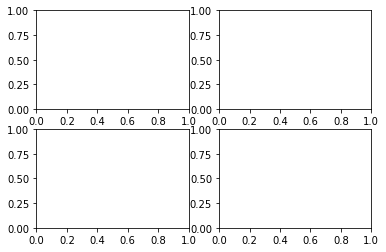

In [11]:
fig, axes = plt.subplots(2, 2)
k = 0
for i in range(2):
    for j in range(2):
        axes[i, j].imshow(saving_frames[k].reshape(129,129), extent=[0, 2, 0, 2], origin='lower', cmap='jet')
        axes[i, j].set_title("patch_" + str(j+1))
        axes[i, j].axis('off')
        k += 1
plt.show()